<a href="https://colab.research.google.com/github/cianhwang/image-mosaic/blob/main/image_mosaic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  Demo notebook: Image mosaicking

Create an image mosaic from image archive.

The example input/output are fresco.jpg and mosaic.png. The image archive used is from [DIV2K dataset](http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import glob
import cv2

In [2]:
def read_image(path):
    image = cv2.imread(path)
    npimg = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)/255.
    return npimg

Download fresco.jpg from GitHub repo and upload it to colab

Or upload your own image and change the path of the following code block.

This image will be used as a template.

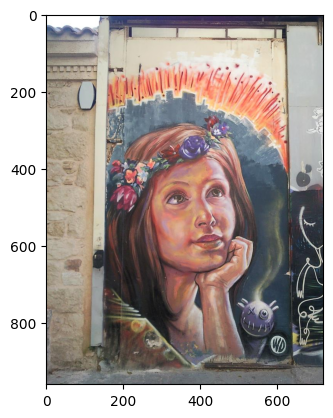

((960, 720, 3), 1.0)

In [3]:
template = read_image('fresco.jpg')
plt.imshow(template)
plt.show()
template.shape, template.max()

Download image archive that will be used to construct image mosaic.

In [ ]:
! wget http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip
! unzip DIV2K_train_HR.zip

Or you can upload your image folder to colab and change the path of the following code block.

In [5]:
files = glob.glob('DIV2K_train_HR/*.png')
files[:5], len(files)

(['DIV2K_train_HR/0492.png',
  'DIV2K_train_HR/0627.png',
  'DIV2K_train_HR/0621.png',
  'DIV2K_train_HR/0327.png',
  'DIV2K_train_HR/0432.png'],
 800)

check if image can be loaded.

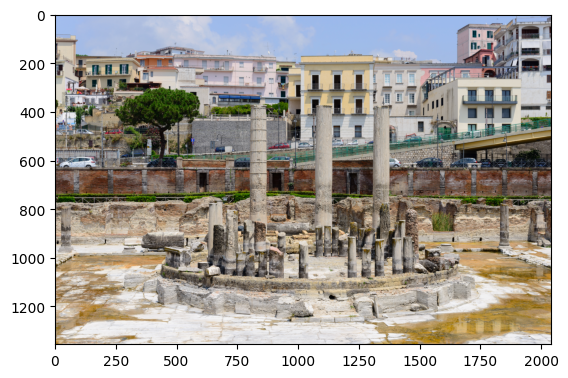

(1356, 2040, 3)

In [6]:
file = files[0]
image = read_image(file)
plt.imshow(image)
plt.show()
image.shape

specify the patch size.

In [7]:
x, y = 16, 16

load image from archive and resize it to the specific patch size

In [8]:
patches = []
for file in files:
    patch = read_image(file)
    patch = cv2.resize(patch, (y, x))
    patch = patch.reshape((x*y, 3))
    patches.append(patch)
patches = np.stack(patches)
patches.shape

(800, 256, 3)

compare, select and stick patches according to the template

In [9]:
patches_norm = patches/(np.sum(patches**2,axis=1, keepdims=True)+1e-15)**0.5
patches_norm_flat = patches_norm.reshape((patches.shape[0], x*y*3))

In [10]:
patches_norm_flat_copy = patches_norm_flat.copy()

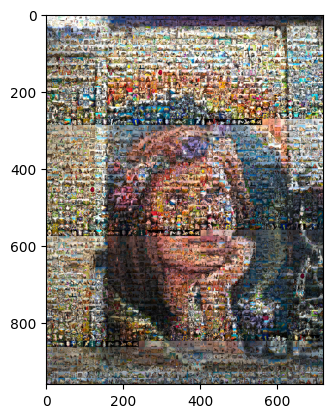

In [11]:
blank_image = np.zeros_like(template)
for i in range(template.shape[0]//x):
    for j in range(template.shape[1]//y):
        tp = template[i*x:i*x+x, j*y:j*y+y].flatten()[:, np.newaxis]
        idx = np.argmax(np.dot(patches_norm_flat, tp)[:,0])
        norm_of_each_channel = np.linalg.norm(template[i*x:i*x+x, j*y:j*y+y].reshape((x*y, 3)), axis=0, keepdims=True)
        matched_patch = patches_norm_flat[idx].reshape((x, y, 3))*norm_of_each_channel[np.newaxis, ...]
        blank_image[i*x:i*x+x, j*y:j*y+y] = matched_patch
        patches_norm_flat[idx] = 0.
        if patches_norm_flat.sum() == 0.:
            patches_norm_flat = patches_norm_flat_copy.copy()
plt.imshow(blank_image)

image mosaic will be saved to mosaic.png

In [12]:
cv2.imwrite('mosaic.png', blank_image[..., ::-1]*255.0)

True